In [1]:
# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import FISTA, HybridGLSQR, GLSQR, LSQR
from cil.optimisation.utilities.HybridUpdateReg import UpdateRegDiscrep, UpdateRegGCV, UpdateRegLcurve, UpdateRegReginska, UpdateRegUPRE

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# CIL data structures and utilities
from cil.utilities.display import show2D

# Third-party imports
import numpy as np    

## Load ISIS cylinder data
Set the desired exposure time and number of angles, then read the data.

Next we get the data geometries and define the projection operator. We also bin the data in half in all dimensions to speed-up the computations.

### Exposure time and number of angles options

| Parameter | Dataset 1 | Dataset 2 | Dataset 3 | Dataset 4 | Dataset 5 | Dataset 6 | Dataset 7 |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **Exposure Time (s)** | 7.5 | 15 | 30 | 60 | 60 | 60 | 60 |
| **Number of Angles** | 840 | 420 | 210 | 105 | 210 | 240 | 840 |

In [ ]:
from data_loader import load_and_process_cylinder

filename = "/home/dnz75396/preprocessed_data"
data, ig,ag = load_and_process_cylinder(dataset_no=4,reduce_size=True, 
                                        filename=filename)
A = ProjectionOperator(ig, ag, device = "gpu")

# Color bar for all images
cbar = (0.0,2.0)

New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0.0412434, 0.       , 0.       ]
	Rotation axis direction: [0.00258149, 0.        , 0.99999667]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [310 775]
	Pixel size: [0.0096 0.0096]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 210
	Angles 0-9 in degrees: [ 0.   ,  1.716,  3.432,  5.148,  6.864,  8.58 , 10.296, 12.012, 13.728,
 15.444]
	Angles 200-209 in degrees: [343.2  , 344.916, 346.632, 348.348, 350.064, 351.78 , 353.496, 355.212,
 356.928, 358.644]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (775, 210, 310)
New geometry shape:  (775, 210, 310)
Number of channels: 1
channel_spacing: 1.0
voxel_num : x310,y310,z775
voxel_

# Inverse problems: LSQR, Tikhonov regularization, and hybrid methods

## LSQR with standard Tikhonov regularization

Next consider the Tikhonov regularized problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2 + \alpha^2 \begin{Vmatrix}u\end{Vmatrix}_2^2$$

where $\alpha$ is the regularization paramater and the regularization term is the norm of $u$.

The magnitude of the regularization parameter balances the goodness-of-fit to the data (the data fidelity term $\begin{Vmatrix}A u - b\end{Vmatrix}$) and the norm of the reconstructed image (the regularization term $\begin{Vmatrix}u\end{Vmatrix}$). Inclusion of the regularization term means that we hopefully don't fit to noise in the data, but only the high frequency components.

The traditional set-up in CIL is to re-write the regularized problem in block matrix form

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{A}{\alpha I} u - \binom{b}{0}\end{Vmatrix}^2_2,$$

where $I$ is the identity operator.

With the definitions:

- $\tilde{A} = \binom{A}{\alpha I}$, 

- $\tilde{b} = \binom{b}{0}$

this can now be recognised as a least squares problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$

and being a least squares problem, it can be solved using LSQR with $\tilde{A}$ as operator and $\tilde{b}$ as data.

However, an important quality of LSQR is that regularize-then-project is equivalent to project-then-regularize. This means we don't have to define a block-operator and deal with higher memory costs throughout the iterative algorithm.

### Regularize-then-project = project-then-regularize

As previously described, when using LSQR on the un-regularized least squares problem, we define a small-dimensional problem with $B_k$ and solve that exactly. If we set out to solve
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2 + \alpha^2 \begin{Vmatrix}u\end{Vmatrix}_2^2,$$
one approach is the following:
1. Define $\tilde{A} = \binom{A}{\alpha I}$, $\tilde{b} = \binom{b}{0}$
2. Build the Krylov subspace associated to $\tilde{A}$ and $\tilde{b}\,$: $\,\mathcal{K}_k(\tilde{A}^T\tilde{A},\, \tilde{A}^T\tilde{b})$.
3. At each iteration, solve the subproblem
$$ u_k(\alpha) = \underset{u\in\mathcal{K}_k(\tilde{A}^T\tilde{A},\, \tilde{A}^T\tilde{b})}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2.$$
Alternatively, one may
1. Build the Krylov subspace associated to $A$ and $b\,$: $\,\mathcal{K}_k(A^TA,\, A^Tb)$.
2. At each iteration, solve the subproblem
\begin{equation*}
    u_k(\alpha) = \underset{u\in\mathcal{K}_k(A^TA,\, A^Tb)}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|u\|_2^2.
\end{equation*}
by solving
\begin{equation*}
    \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}\begin{bmatrix}B_k \\ \alpha I \end{bmatrix}y - \|b\|e_1 \end{Vmatrix}_2^2,
\end{equation*}
where $B_k$ is the bidiagonal matrix as before.

The upside is that we work with smaller vectors throughout, reducing the computational effort and memory cost. The adaption to the code is minimal, as can be seen from the code excerpt below.


# Choosing a good regularization parameter

It is difficult to predict a good regularization parameter $\alpha$ a priori. Let's investigate the reconstruction for a couple of different parameters. We use LSQR for the reconstructions, where we simply pass the regularization parameter to LSQR:

\begin{align*}
&\texttt{lsqr = LSQR(operator=A, data=data, alpha=alpha)} \\
&\texttt{lsqr.run(iterations=maxit, verbose=True)}
\end{align*}

In [ ]:
# Try different regularization parameters and observe reconstructions
alphavec = [0, 0.1, 0.5,  1, 1.5, 2]
maxit = 50

lsqrlist = []
for alpha in alphavec:
    lsqr = LSQR(operator=A, data=data, alpha=alpha)
    lsqr.run(iterations=maxit, verbose=True)
    lsqrlist.append(lsqr.solution)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
# Define the list of solutions and titles once

solutions = lsqrlist


titles = [
    f'alpha = {alphavec[0]:.3f}',
    f'alpha = {alphavec[1]:.3f}', 
    f'alpha = {alphavec[2]:.3f}', 
    f'alpha = {alphavec[3]:.3f}',
    f'alpha = {alphavec[4]:.3f}',
    f'alpha = {alphavec[5]:.3f}',
]

# Mapping for the dropdown
rule_options = {
    'All Rules': None,
    titles[0]: 0,
    titles[1]: 1,
    titles[2]: 2,
    titles[3]: 3,
    titles[4]: 4,
    titles[5]: 5,
}

def update_display(vslice, rule_name,norm_name='L2'):
    # Determine which solutions to show
    idx = rule_options[rule_name]
    
    if idx is None:
        # Show all
        current_solutions = solutions
        current_titles = titles
        cols = 4
    else:
        # Show only the selected one
        current_solutions = [solutions[idx]]
        current_titles = [titles[idx]]
        cols = 1

    # Render using show2D
    fig = show2D(
        current_solutions,
        cmap='inferno', 
        slice_list=('vertical', vslice), 
        num_cols=cols,
        fix_range=cbar,
        title=current_titles
    )
    
    # Add the overall title (suptitle)
    # We use plt.gcf() to ensure we grab the figure show2D just created
    fig = plt.gcf()
    fig.suptitle(f"Standard Tikhonov Analysis {norm_name}\nRule: {rule_name} | Vertical Slice: {vslice}", 
                 fontsize=14, fontweight='bold', y=1.05)
    
    # Adjust layout so the suptitle doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Determine dimensions
max_vslice = solutions[0].shape[0] - 1

# Create the interactive dashboard
interact(
    update_display, 
    vslice=IntSlider(min=0, max=max_vslice, step=1, value=200, description='Slice:'),
    rule_name=Dropdown(options=list(rule_options.keys()), value=titles[0], description='Rule:')
);

interactive(children=(IntSlider(value=69, description='Slice:', max=69), Dropdown(description='Rule:', index=1…

From a visual inspection, it seems that the optimal regularization parameter is around $\alpha \in (0.5,1)$. For smaller values of $\alpha$, artefacts are present in the reconstruction. For greater values of $\alpha$, the reconstruction is over-smoothed. Can we find a good value of $\alpha$ without computing doing lots of reconstructions?


# Hybrid Krylov subspace methods

## Introduction

We set out to estimate a good parameter without computing various reconstructions. We will resort to hybrid Krylov subspace methods for this.

As previously explained, within LSQR, at the $k$-iteration we have made the approximation:

\begin{equation*}
    \underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 \approx \underset{u\in\mathcal{K}_k(A^TA,\,A^Tb)}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 =: x_k
\end{equation*}    

and we have simplified this to
\begin{equation*}    
    y_k = \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}B_ky - \|b\|e_1\end{Vmatrix}, \quad x_k = V_ky_k,
\end{equation*}
where $B_k$ is the bidiagonal matrix as before and $V_k$ is the orthonormal basis for the $k$-dimensional Krylov subspace $\mathcal{K}_k(A^TA,\,A^Tb)$.

Now, if we include Tikhonov regularization, setting out the solve 
\begin{equation*}
    \underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|u\|_2^2 \approx \underset{u\in\mathcal{K}_k(A^TA,\,A^Tb)}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|u\|_2^2 =: x_k(\alpha),
\end{equation*}    

we find the simplified subproblem
\begin{equation*}    
    y_k(\alpha) = \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}B_ky - \|b\|e_1\end{Vmatrix}_2^2 + \alpha^2\|y\|_2^2 = \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}\begin{bmatrix}B_k \\ \alpha I\end{bmatrix} y - \|b\|e_1\end{Vmatrix}_2^2, \quad x_k(\alpha) = V_ky_k(\alpha)
\end{equation*}

In a hybrid method, we use an automatic regularization parameter selection rule at  the small(!) subproblem

## Automatic regularization parameter selection


We will first introduce some automatic regularization parameter rules. We introduce them for the full problem 
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|u\|_2^2,$$
to build intuition. Then we introduce the computational cost associated to applying the rule to the small projected problem
$$ \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}B_ky - \|b\|e_1\end{Vmatrix}_2^2 + \alpha^2\|y\|_2^2.$$

### Discrepency principle

The discrepency principle requires an estimate of the magnitude of the noise $\|\eta\|$ as input. It then seeks to find a regularized solution such that:
$$\|Au(\alpha)-b\|_2^2 = \tau \|\eta\|_2^2,$$
where $\tau$ is some small safety parameter. Computing such an $\alpha$ for the full problem with $A$ is computationally infeasible, as it would require either computing many solutions $u(\alpha)$ for different values of $\alpha$ or the singular value decomposition (SVD) of $A$. This is why we apply the discrepency principle to the small projected problem.

In our hybrid scheme, we have at an iteration $k$ that 
$$y_k(\alpha) = \underset{y\in\mathbb{R}^k}{\mathrm{argmin}}\begin{Vmatrix}B_ky - \|b\|e_1\end{Vmatrix}_2^2 + \alpha^2\|y\|_2^2.$$
We then find the associated regularization parameter $\alpha_k$, we must solve
$$\mathrm{find}\,\, \alpha_k\, \, \mathrm{such\,\, that} \begin{Vmatrix}B_ky_k(\lambda_k) - \|b\|e_1\end{Vmatrix}_2^2 = \tau \|\eta\|_2^2.$$
If we have a singular value decomposition $$B_k = P_k\begin{bmatrix}\Sigma_k \\ 0 \end{bmatrix} Q_k^T,$$ then $y_k(\lambda)$ can be expressed as
$$y_k(\lambda) = \|b\|Q_k(\Sigma_B^2 + \alpha^2 I)^{-1}\Sigma_B P_{:,1:k}^Te_1,$$
so we find $\alpha\geq 0$ that satisfies
$$\tau \|\eta\|_2^2 = \|b\|_2^2\left(\left\|\alpha^2(\Sigma_k^2 + \alpha^2I)^{-1}P_{:,1:k}^Te_1 \right\|_2^2 + \left\|p_{k+1}^Te_1 \right\|_2^2\right).$$
This root-finding problem is solved with $\texttt{scipy.optimize.root\_scalar}$ and target function
$$f(\alpha) = \|b\|_2^2\left(\left\|\alpha^2(\Sigma_k^2 + \alpha^2I)^{-1}P_{:,1:k}^Te_1 \right\|_2^2 + \left\|p_{k+1}^Te_1 \right\|_2^2\right)  - \tau \|\eta\|_2^2.$$
This root-finding problem is solved at every iteration, as the singular value decomposition of $B_k$ is updated. This gives us a sequence of regularization parameters $\alpha_1,\dots, \alpha_k$. We state that the parameter has converged at iteration $k$ if 
$$ \frac{|\alpha_k - \alpha_{k-1}|}{\alpha_k} < \texttt{tol}_{\alpha},$$
where the tolerance $\texttt{tol}_{\alpha}$ is a user-input.


### Generalized Cross-Validation: standard, weighted, and adaptive

Cross validation is a data fitting technique that aims to minimise noise-effects by fiting to a subset of the data, and ensuring the fit is good on an unseen subset of the data. Generalized cross validation (GCV) is a rotation-invariant version of ordinary cross validation, employing a leave-one-out prediction method (see Golub, Heath, and Wahba, 1979). We set out to minimize the GCV function
$$G(\alpha) = \frac{\|Au(\alpha) - b\|_2^2}{\textrm{trace}\,(I - AA_{\alpha}^{\#})},$$
where $A_{\alpha}^{\#}$ is the ``regularized inverse'' given by $A_{\alpha}^{\#}(A^TA + \alpha^2I)^{-1}A^T$. 

Again, computing the minimizer $\alpha^*$ of $G(\alpha)$ is computationally infeasible as it requires the SVD of $A$. We instead minimize the GCV function associated to the projected problem with $B_k$. Again, let $$B_k = P_k\begin{bmatrix}\Sigma_k \\ 0 \end{bmatrix} Q_k^T$$ be an SVD and let $p_i$ denote the columns of $P_k$ and $\sigma_i$ the singular values in $\Sigma_k$. Then
\begin{align*}
G_k(\alpha) &= \frac{\|B_ky(\alpha) - \|b\|e_1\|_2^2}{\textrm{trace}\,(I - B_kB_{k,\alpha}^{\#})}\\
&= k\|b\|^2\frac{\left(\sum_{i=1}^k\left(\frac{\alpha^2p_i^Te_1}{\sigma_i^2+\alpha^2}\right)^2 + (p_{k+1}^Te_1)^2\right)} {\left(1 + \sum_{i=1}^k \frac{\alpha^2}{\sigma_i^2 + \alpha^2}\right)^2}.
\end{align*}
Standard GCV minimizes this functional using $\texttt{scipy.optimize.fmin}$.

Chung, Nagy, and O'Leary (2008) report that GCV sometimes underperforms, exhibiting semiconvergent behaviour. They propose a weighted GCV (W-GCV) method, with W-GCV function
$$G(\omega, \alpha) = \frac{\|Au(\alpha) - b\|_2^2}{\textrm{trace}\,(I - \omega AA_{\alpha}^{\#})}.$$
For the projected problem, the W-GCV function has the form
\begin{equation*}
G_k(\omega, \alpha) = k\|b\|^2\frac{\left(\sum_{i=1}^k\left(\frac{\alpha^2p_i^Te_1}{\sigma_i^2+\alpha^2}\right)^2 + (p_{k+1}^Te_1)^2\right)} {\left(1 + \sum_{i=1}^k \frac{(1-\omega)\sigma_i^2 + \alpha^2}{\sigma_i^2 + \alpha^2}\right)^2}.
\end{equation*}
It is not clear how to choose a good value for $\omega$. For this reason, Chung, Nagy, and O'Leary (2008) introduce an adaptive W-GCV method, where $\omega$ is chosen adaptively and is updated at every iteration. We next explain this adaptive procedure. 

In early iterations, the projected problem with $B_k$ is meant to capture the high-frequency components of $A$. We assume that little or no regularization is necessary here, and thus that the optimal regularization parameter $\alpha_k^*$ should satisfy
$$0\leq \alpha_k^* \leq \sigma_{\min}(B_k),$$
where $\sigma_{\min}(B_k)$ is the smallest singular value of $B_k$. If we assume that the optimal parameter is exacly $\sigma_{\min}(B_k)$, then we can find the optimal $\omega_k^*$ by ensuring
$$\textrm{find}\,\,\omega_k^* \,\, \textrm{such\,\, that}\,\, \frac{\delta}{\delta \alpha}G_k(\omega_k^*, \alpha)\vert_{\lambda = \sigma_{\min}(B_k)} = 0$$
We call the $\omega$ found with this root-finding problem $\hat{\omega}_k$. If $\sigma_{\min}(B_k)$ is greater than some tolerance $\texttt{tol}_{\sigma}$, then $\omega_k = \hat{\omega}_k$.

In later iterations, $B_k$ will inheret more and more of the ill-conditioning present in $A$. As a result, we would likely need 
$$\alpha_k^* > \sigma_{\min}(B_k).$$
For these iterations, where $\texttt{tol}_{\sigma} \geq \sigma_{\min}(B_k)$ we take,
$$\omega_k = \textrm{mean}\,\{\hat{\omega}_1,\dots,\hat{\omega}_k\}.$$

There are two simultaneous stopping criteria suggested in Chung, Nagy, and O'Leary (2008). For either, we define a new GCV function that combines $G$ and $G_k$. Define
$$\hat{G}(k) = n\|b\|^2\frac{\left(\sum_{i=1}^k\left(\frac{\alpha_k^2p_i^Te_1}{\sigma_i^2+\alpha_k^2}\right)^2 + (p_{k+1}^Te_1)^2\right)} {\left((m-k) + \sum_{i=1}^k \frac{\alpha_k^2}{\sigma_i^2 + \alpha_k^2}\right)^2},$$
where $m\times n$ are the dimensions of $A$. 

The first stopping criterium is to stop when the function $\hat{G}$ changes very little:
$$ \frac{|\hat{G}(k) - \hat{G}(k-1)|}{|\hat{G}(1)|} < \texttt{tol}_{G},$$
where the tolerance $\texttt{tol}_{G}$ is a user-input. The second is to stop when then GCV values $\hat{G}(k)$ start to increase. Then, we stop at iteration $k_0$ for which
$$k_0 = \mathrm{argmin}\,\hat{G}(k),$$
and set $\alpha = \alpha_{k_0}$.


There exist a scala of automatic regularization parameter methods. Prominent methods include the L-curve rule, unbiased predictive rule, and the Reginska criterion. These methods require implementation. Details can be found in Gazzola and Sabate Landman (2020). 

## Hybrid methods in action Tikhonov Regularization

1. Discrepency
2. GCV
3. Weighted GCV
4. Adaptive Weighted GCV
5. Reginska
6. UPRE
7. L-curve


In [5]:
# We set a tolerance, an initial guess, and a maximum number of iterations
alpha_tol = 1e-2
maxit = 50
initial = A.domain_geometry().allocate(0)

# Define noise level
noise_std = 0.5 * np.std(data.array) 
noiselevel = 0.3 * np.linalg.norm(data.array)
noisevariance = noise_std**2

## 1. Discrepency Rule

In [6]:
discrep_rule = UpdateRegDiscrep(data_size=data.size,
                                domain_size=initial.size, 
                                tol=1e-2,
                                noise_level_estimate=noiselevel)

hybridlsqrD = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=discrep_rule)
hybridlsqrD.run(maxit, verbose=True)


  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 0.025866767343005765 in 50 iterations


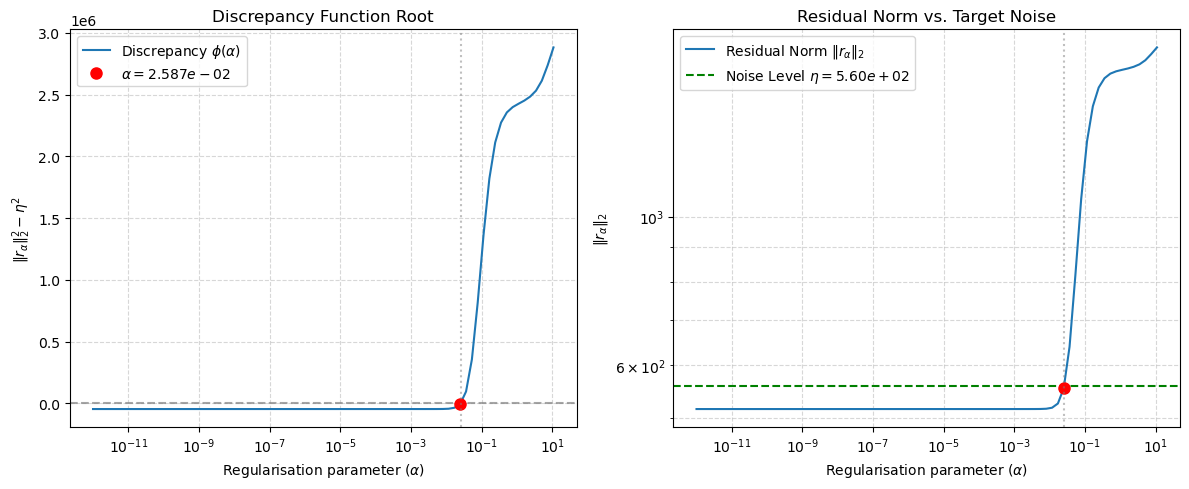

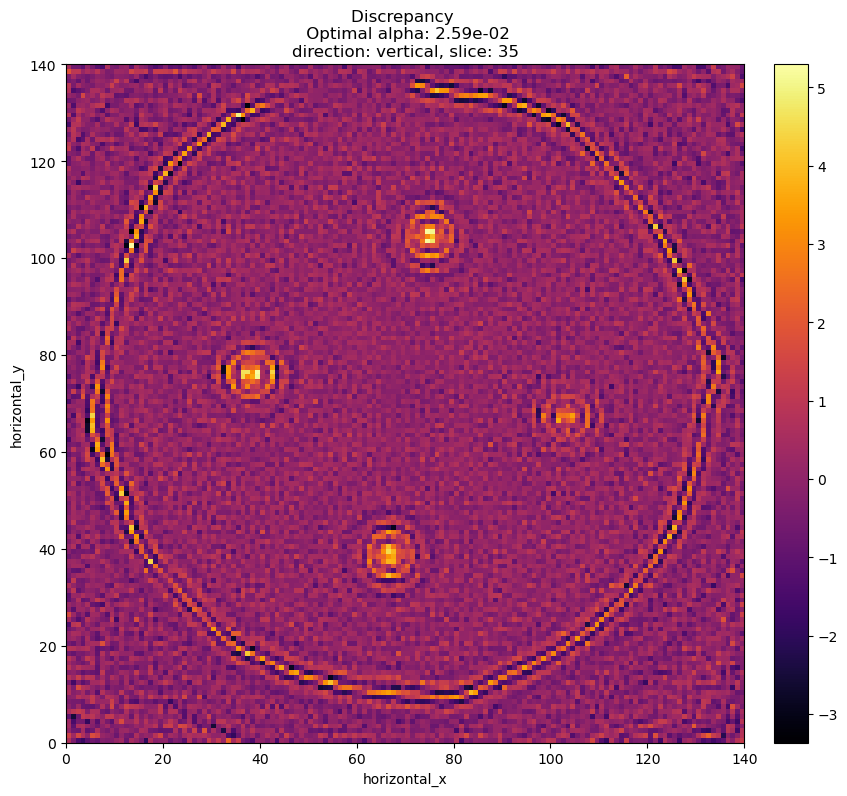

In [ ]:
print("The optimal parameter it finds is", hybridlsqrD.regalpha, "in", hybridlsqrD.iteration, "iterations")

hybridlsqrD.reg_rule.plot_function()
#hybridlsqrD.reg_rule.plot_history()

show2D(hybridlsqrD.solution,
        title=f"Discrepancy \n Optimal alpha: {hybridlsqrD.regalpha:.2e}",
        fix_range=cbar,
        cmap="inferno")

## 2. Standard GCV Rule

In [8]:
gcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                adaptive_weight=False)

hybridlsqrgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=gcv_rule)
hybridlsqrgcv.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 7.057589927224932 in 7 iterations


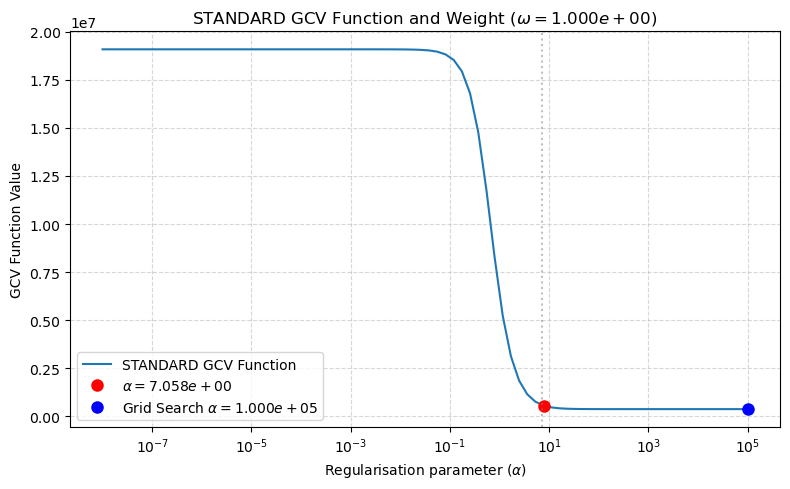

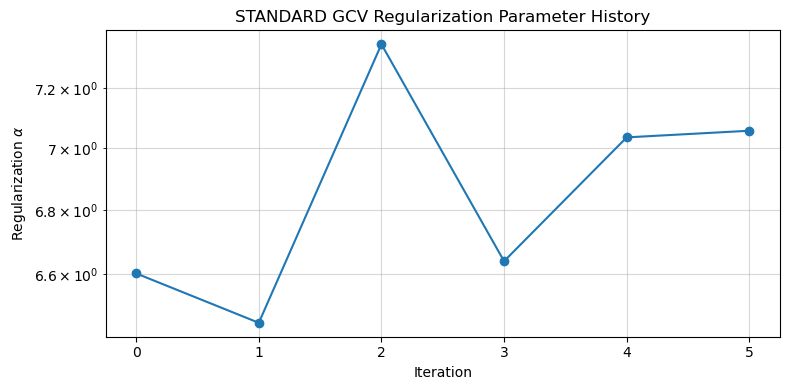

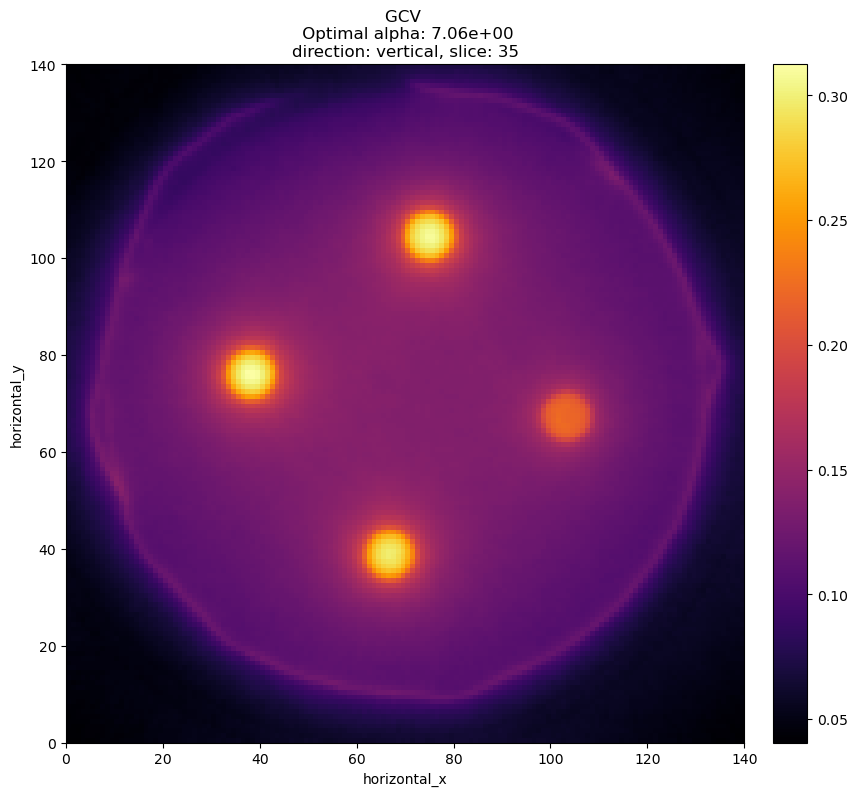

In [ ]:
print("The optimal parameter it finds is", hybridlsqrgcv.regalpha, "in", hybridlsqrgcv.iteration, "iterations")

hybridlsqrgcv.reg_rule.plot_function(regalpha_limits=(1e-8, 1e5))
hybridlsqrgcv.reg_rule.plot_history()

show2D(hybridlsqrgcv.solution,
        title=f"GCV \n Optimal alpha: {hybridlsqrgcv.regalpha:.2e}",
        fix_range=cbar,
        cmap="inferno")

## 3. Weighted GCV Rule

In [10]:
wgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=False)

hybridlsqrwgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=wgcv_rule)
hybridlsqrwgcv.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 7.057589927224932 in 7 iterations


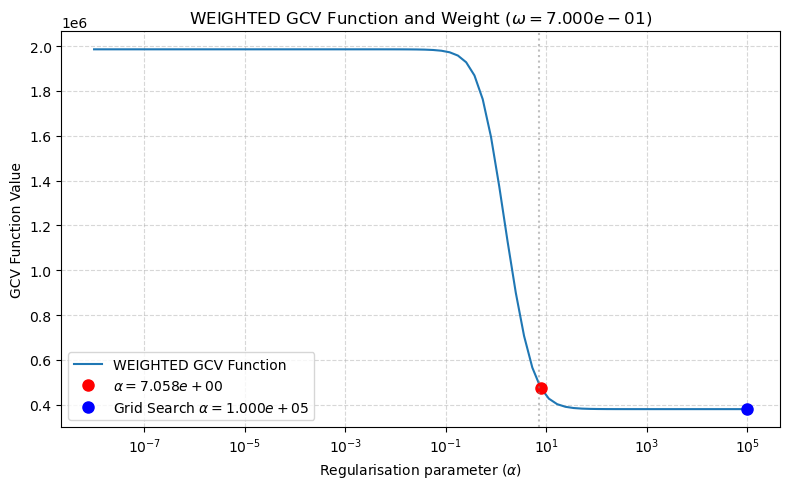

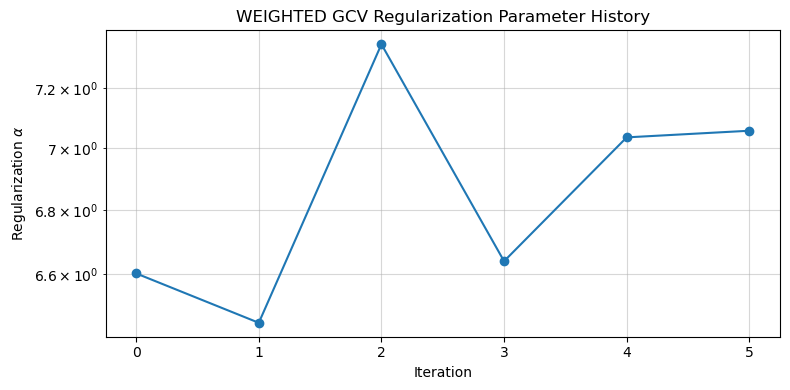

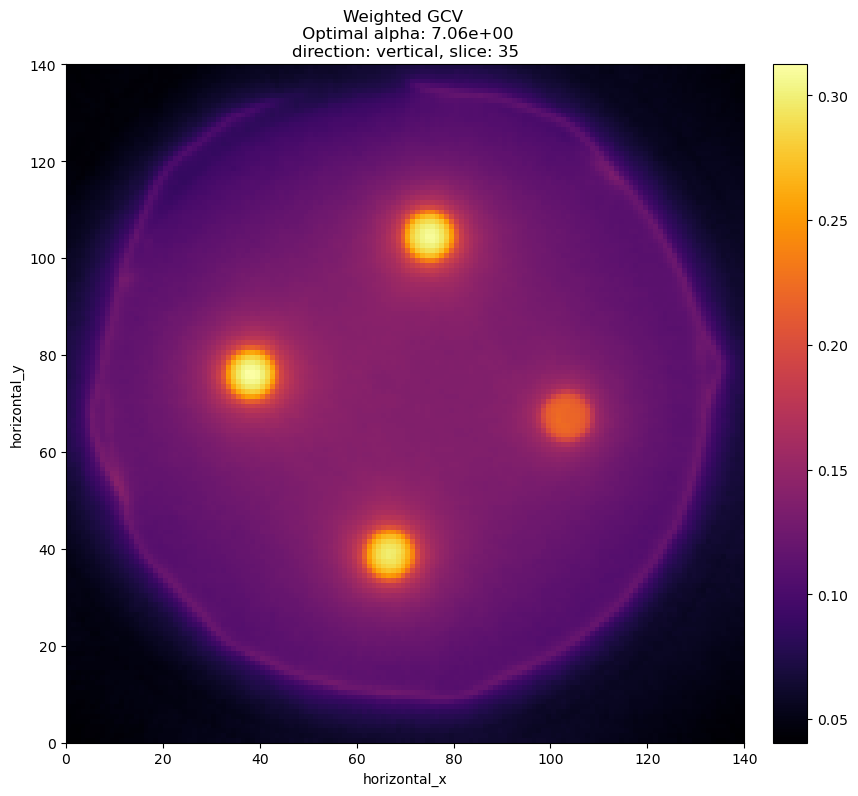

In [ ]:
print("The optimal parameter it finds is", hybridlsqrwgcv.regalpha, "in", hybridlsqrwgcv.iteration, "iterations")

hybridlsqrwgcv.reg_rule.plot_function(regalpha_limits=(1e-8, 1e5))
hybridlsqrwgcv.reg_rule.plot_history()

show2D(hybridlsqrwgcv.solution,
        title=f"Weighted GCV \n Optimal alpha: {hybridlsqrwgcv.regalpha:.2e}",
        fix_range=cbar,
        cmap="inferno")

## 4. Adaptive-Weighted GCV Rule

In [12]:
awgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=True)

hybridlsqrawgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=awgcv_rule)
hybridlsqrawgcv.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 7.057589927224932 in 7 iterations


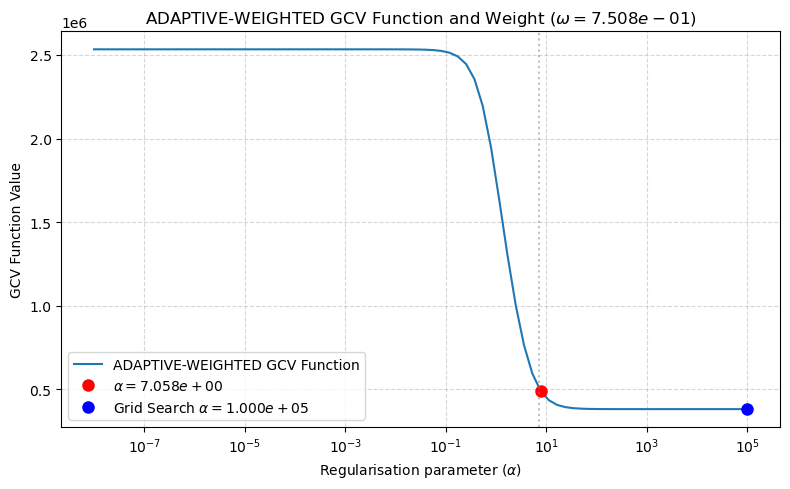

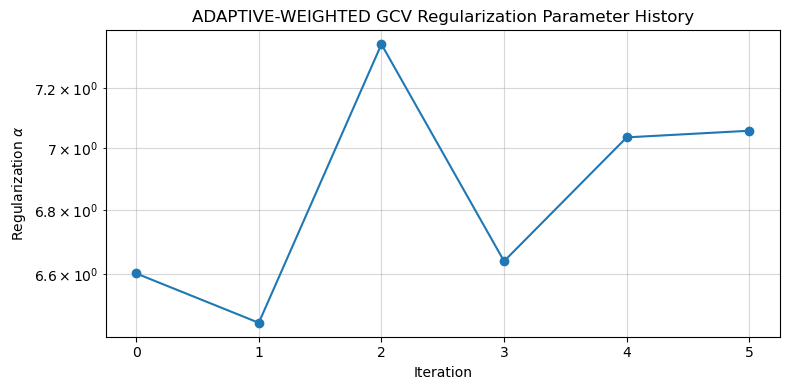

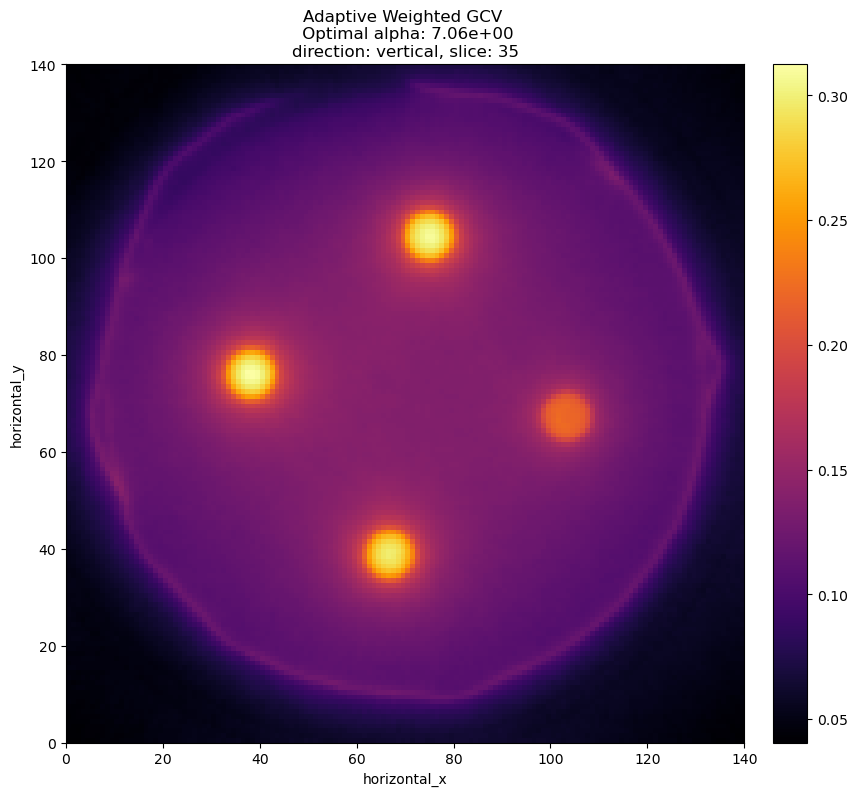

In [ ]:
print("The optimal parameter it finds is", hybridlsqrawgcv.regalpha, "in", hybridlsqrawgcv.iteration, "iterations")

hybridlsqrawgcv.reg_rule.plot_function(regalpha_limits=(1e-8, 1e5))
hybridlsqrawgcv.reg_rule.plot_history()

show2D(hybridlsqrawgcv.solution,
        title=f"Adaptive Weighted GCV \n Optimal alpha: {hybridlsqrawgcv.regalpha:.2e}",
        fix_range=cbar,
        cmap="inferno")

## 5. Reginska Rule

In [14]:
reginska_rule = UpdateRegReginska(data_size=data.size,
                                domain_size=initial.size, 
                                tol=0.1,
                                mu=1.0)

hybridlsqrreginska = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=reginska_rule)
hybridlsqrreginska.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 6.450358634200156 in 3 iterations


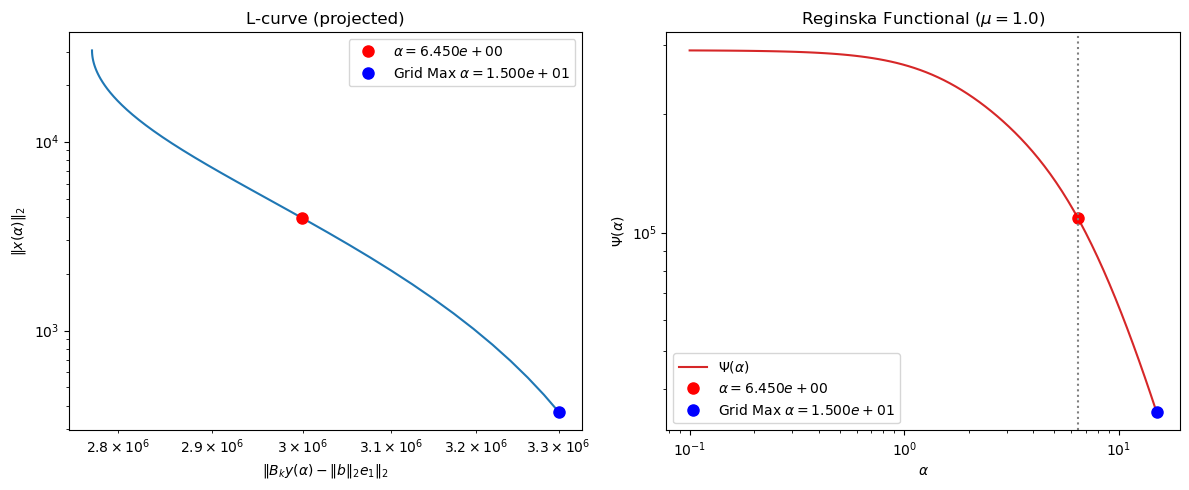

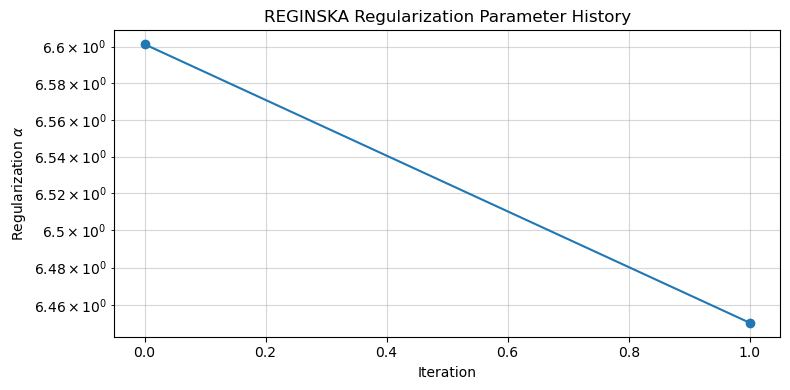

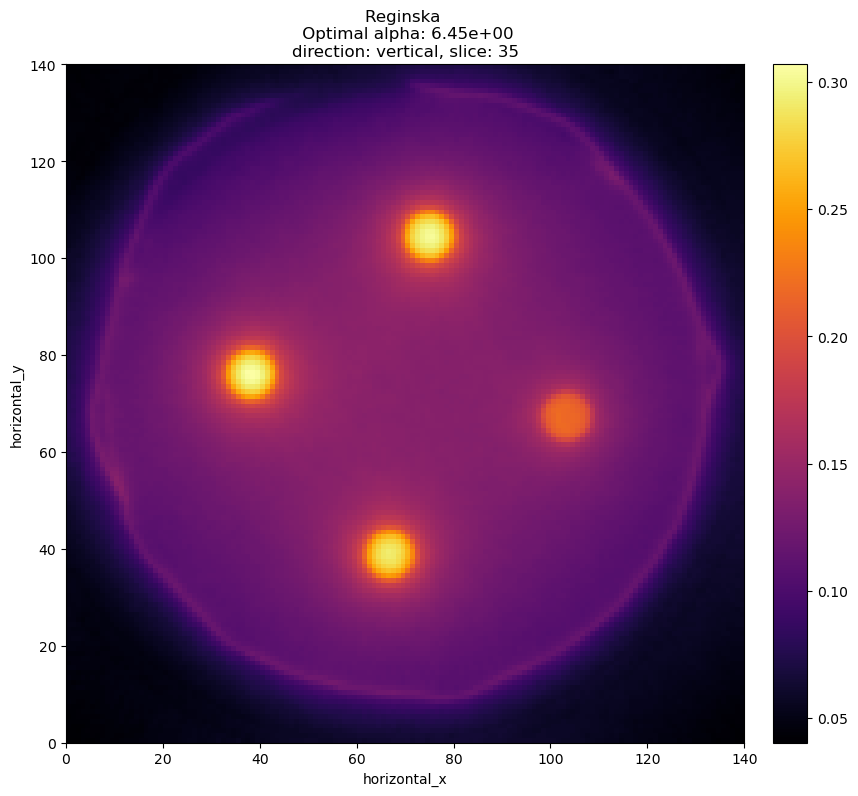

In [15]:
print("The optimal parameter it finds is", hybridlsqrreginska.regalpha, "in", hybridlsqrreginska.iteration, "iterations")

hybridlsqrreginska.reg_rule.plot_function(regalpha_limits=(1e-1, 1.5e1))
hybridlsqrreginska.reg_rule.plot_history()

show2D(hybridlsqrreginska.solution,
        title=f"Reginska \n Optimal alpha: {hybridlsqrreginska.regalpha:.2e}",
        cmap="inferno")

## 5. UPRE Rule

In [16]:
upre_rule = UpdateRegUPRE(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                noise_variance=noisevariance)

hybridlsqrupre = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=upre_rule)
hybridlsqrupre.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 1e-12 in 24 iterations


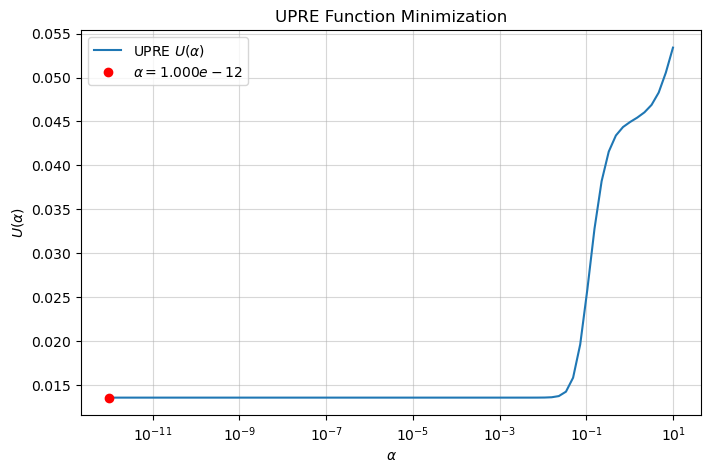

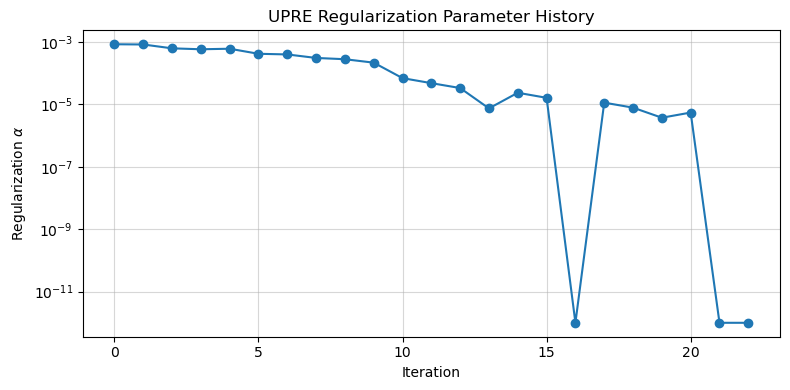

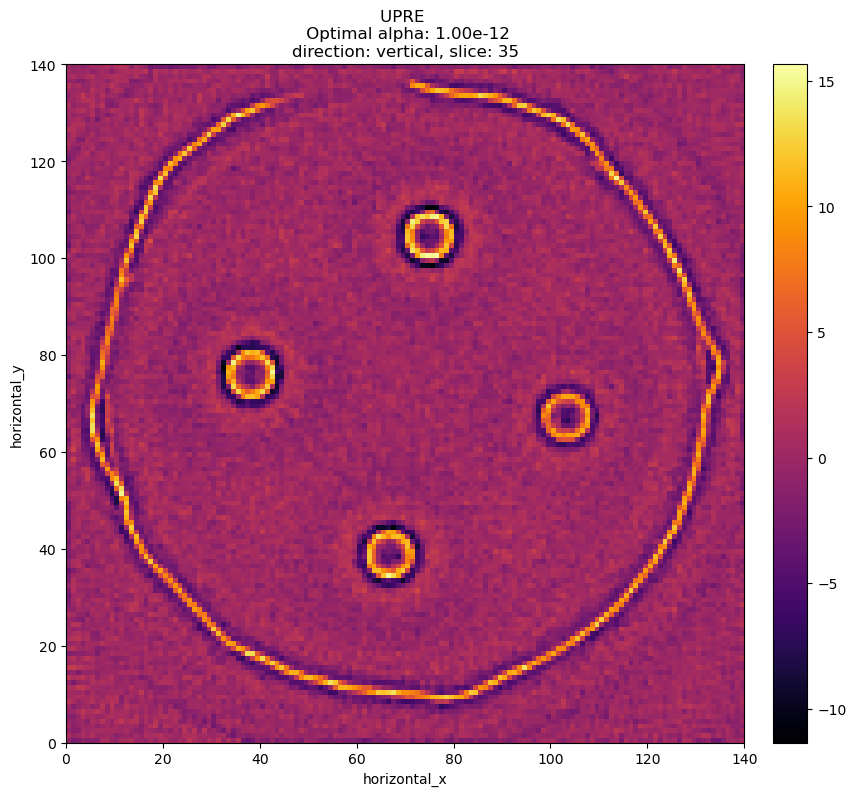

In [ ]:
print("The optimal parameter it finds is", hybridlsqrupre.regalpha, "in", hybridlsqrupre.iteration, "iterations")

hybridlsqrupre.reg_rule.plot_function()
hybridlsqrupre.reg_rule.plot_history()

show2D(hybridlsqrupre.solution,
        title=f"UPRE \n Optimal alpha: {hybridlsqrupre.regalpha:.2e}",
        fix_range=cbar,
        cmap="inferno")

## 7. L-curve Rule

In [18]:
lcurve_rule = UpdateRegLcurve(data_size=data.size,
                                domain_size=initial.size, 
                                tol=1e-2)

hybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=lcurve_rule)
hybridlsqrlcurve.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 2.806435845536603 in 9 iterations


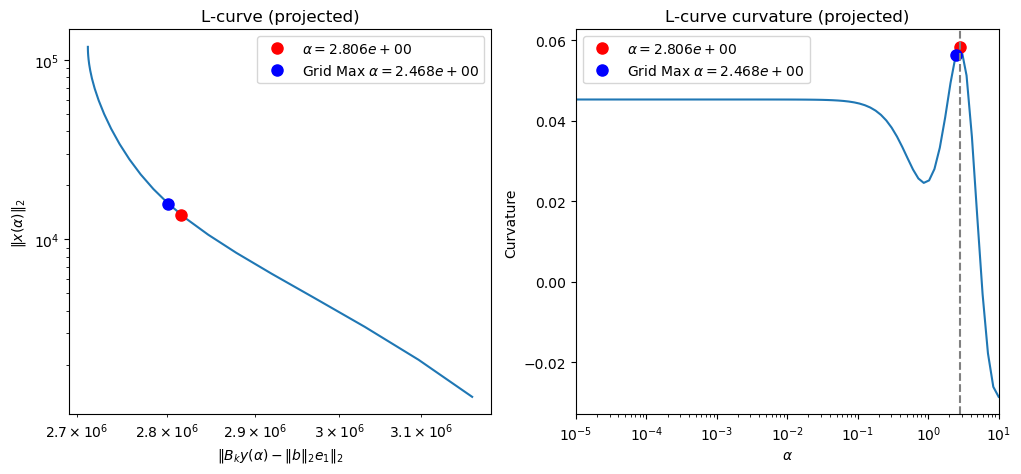

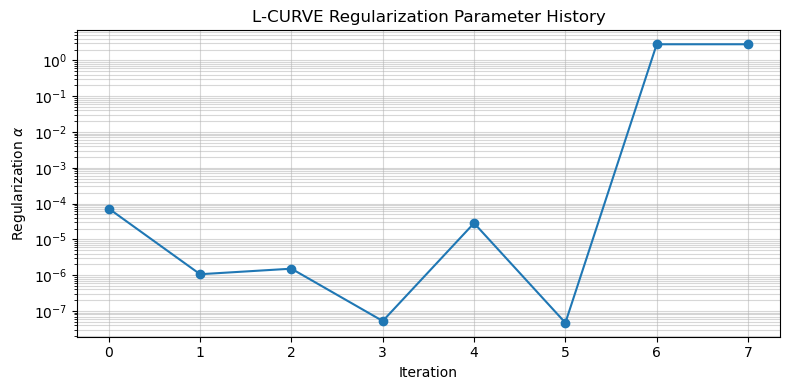

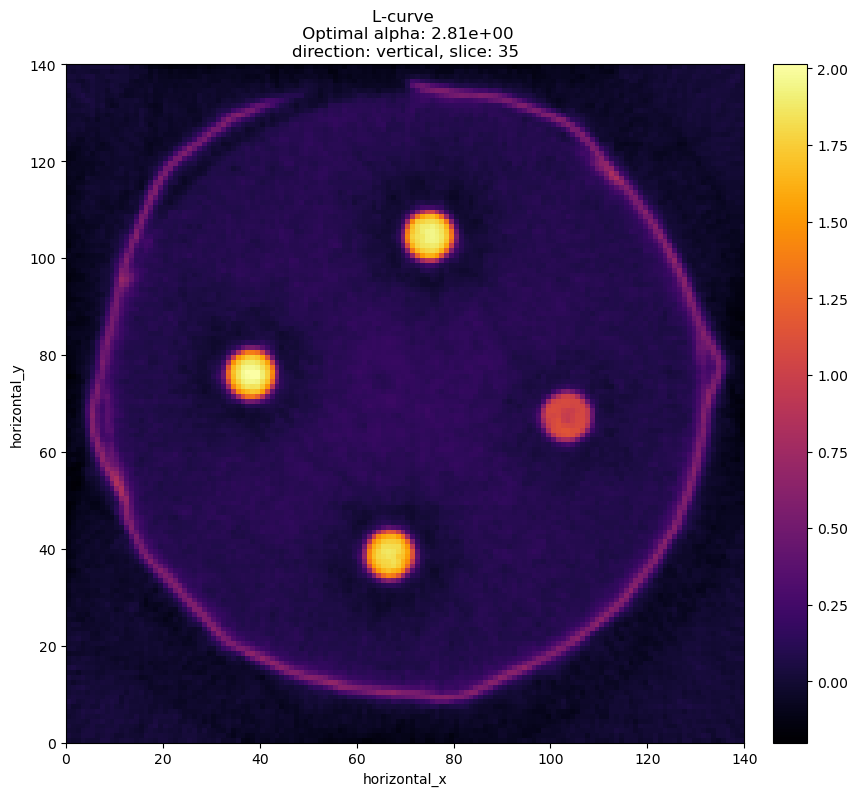

In [ ]:
print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")

hybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-5, 1e1))
hybridlsqrlcurve.reg_rule.plot_history()

show2D(hybridlsqrlcurve.solution,
        title=f"L-curve \n Optimal alpha: {hybridlsqrlcurve.regalpha:.2e}",
        fix_range=cbar,
        cmap="inferno")

## Display Results
The results are shown in the figure below. 

In [ ]:
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
# Define the list of solutions and titles once

solutions = [hybridlsqrD.solution, 
                hybridlsqrgcv.solution, 
                hybridlsqrwgcv.solution, 
                hybridlsqrawgcv.solution,
                hybridlsqrlcurve.solution, 
                hybridlsqrreginska.solution, 
                hybridlsqrupre.solution
                ]


titles = [
    f'Discrep alpha = {hybridlsqrD.regalpha:.2e}',
    f'GCV alpha = {hybridlsqrgcv.regalpha:.2e}', 
    f'WGCV alpha = {hybridlsqrwgcv.regalpha:.2e}', 
    f'AWGCV alpha = {hybridlsqrawgcv.regalpha:.2e}',
    f'LCURVE alpha = {hybridlsqrlcurve.regalpha:.2e}',
    f'REGINSKA alpha = {hybridlsqrreginska.regalpha:.2e}',
    f'UPRE alpha = {hybridlsqrupre.regalpha:.2e}'
]

# Mapping for the dropdown
rule_options = {
    'All Rules': None,
    'Discrepancy': 0,
    'GCV': 1,
    'WGCV': 2,
    'AWGCV': 3,
    'L-Curve': 4,
    'Reginska': 5,
    'UPRE': 6
}

def update_display(vslice, rule_name,norm_name='L2'):
    # Determine which solutions to show
    idx = rule_options[rule_name]
    
    if idx is None:
        # Show all
        current_solutions = solutions
        current_titles = titles
        cols = 4
    else:
        # Show only the selected one
        current_solutions = [solutions[idx]]
        current_titles = [titles[idx]]
        cols = 1

    # Render using show2D
    fig = show2D(
        current_solutions,
        cmap='inferno', 
        slice_list=('vertical', vslice), 
        num_cols=cols,
        fix_range=cbar,
        title=current_titles
    )
    
    # Add the overall title (suptitle)
    # We use plt.gcf() to ensure we grab the figure show2D just created
    fig = plt.gcf()
    fig.suptitle(f"Hybrid GLSQR Analysis {norm_name}\nRule: {rule_name} | Vertical Slice: {vslice}", 
                 fontsize=14, fontweight='bold', y=1.05)
    
    # Adjust layout so the suptitle doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Determine dimensions
max_vslice = solutions[0].shape[0] - 1

# Create the interactive dashboard
interact(
    update_display, 
    vslice=IntSlider(min=0, max=max_vslice, step=1, value=200, description='Slice:'),
    rule_name=Dropdown(options=list(rule_options.keys()), value='All Rules', description='Rule:')
);

interactive(children=(IntSlider(value=69, description='Slice:', max=69), Dropdown(description='Rule:', options…

Some rules seem to result in quite reasonable parameters, while others oversmoothe. 